# Цели и задачи проекта

# Первичный анализ данных
Импортируем библиотеки и прочитаем файл с данными:

In [1]:
import pandas as pd
import numpy as np
from math import nan
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

df = pd.read_csv('stud_math.csv')
df.columns = [col.lower() for col in df.columns]

Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:

In [2]:
display(df.head(10))
df.info()

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Итого 395 строк (в значениях большинства колонок есть пропуски), 30 столбцов. В датасете 13 числовых столбцов, 17 строковых (судя по их типам).

# Функции для работы со столбцами

In [3]:
def get_absence_number(col):
    return (col.isnull() | col.isna()).sum()


def check_discrete_values(col, list_values):
    col_err = col[~col.isin(list_values) & ~col.isnull() & ~col.isna()]
    if col_err.size == 0:
        print('Данные корректны.')
    else:
        if len(col_err.value_counts()) == 1:
            print('Данные не корректны:', col_err.value_counts())
        else:
            print('Данные не корректны:\n', col_err.value_counts())


def check_continuous_values(col, list_borders):
    list_borders = sorted(list_borders)
    col_err = col[(col < list_borders[0]) | (col > list_borders[1]) & ~col.isnull() & ~col.isna()]
    if col_err.size == 0:
        print('Данные корректны.')
    else:
        if len(col_err.value_counts()) == 1:
            print('Данные не корректны:', col_err.value_counts())
        else:
            print('Данные не корректны:\n', col_err.value_counts())


def remove_value(df, col_name, value):
    if (not pd.isnull(value)) and (not pd.isna(value)):
        return df[df[col_name] != value]
    else:
        return df[~(df[col_name].isnull() | df[col_name].isna())]


def get_percentiles(col):
    list_quant = [col.quantile(0.25), col.quantile(0.75)]
    iqr = list_quant[1] - list_quant[0]
    diap = [list_quant[0] - 1.5 * iqr, list_quant[1] + 1.5 * iqr]
    return [list_quant, diap, iqr]


def print_column_info(col):  
    if col.nunique() > 10:
        value_counts_0 = col.value_counts().iloc[:10]
        value_counts_1 = col.value_counts(normalize=True).iloc[:10]
    else:
        value_counts_0 = col.value_counts()
        value_counts_1 = col.value_counts(normalize=True)
        
    df_disp = pd.DataFrame({'Кол-во': value_counts_0.values,
                            '%': 100 * np.round(value_counts_1.values,decimals=3)},
                            index = value_counts_0.index)
    display(df_disp)
   
    if col.nunique() > 10:
        print('... остальные значения')
        
    display(sum(col.value_counts().values))    
    print(f'Количество пропусков: {get_absence_number(col)}')
    print(f'Количество уникальных значений: {col.nunique()}')
    print(f'Количество значений, встретившихся более 10 раз: {(col.value_counts() > 10).sum()}')


def print_column_hist(col, list_borders, list_borders_plot=None):
    list_borders = sorted(list_borders)
    display(col.describe())
    list_perc = get_percentiles(col)
    print(f'25-й перцентиль: {list_perc[0][0]},', f'75-й перцентиль: {list_perc[0][1]}',
          f'\nIQR: {list_perc[-1]},', f'Границы выбросов: [{list_perc[1][0]}, {list_perc[1][1]}].')
    # col.hist(bins=8, range=list_borders, label='IQR')
    if list_borders_plot == None:
        list_borders_plot = (list_borders[0] - 2, list_borders[1] + 2)
    else:
        list_borders_plot = sorted(list_borders_plot)
    col.loc[col.between(list_borders[0], list_borders[1])].hist(alpha=0.5,
                                                                #bins=10,
                                                                range=list_borders_plot,
                                                                label='Здравый смысл')
    col.loc[col.between(list_perc[1][0], list_perc[1][1])].hist(#bins=10,
                                                                range=list_borders_plot,
                                                                label='IQR')
    plt.legend()
    
    
def get_boxplot(df, col_name, idx=None):
    fig, ax = plt.subplots(figsize = (14, 4))
    
    if df[col_name].nunique() < 10:
        df_boxplot = df
    else:
        df_boxplot = df.loc[df.loc[:, col_name].isin(df.loc[:, col_name].value_counts().index[:10])]
    
    sns.boxplot(x=col_name, y='score', data=df_boxplot, ax=ax)
    plt.xticks(rotation=45)
    
    if idx == None:
        ax.set_title('Боксплот для ' + col_name)
    else:
        ax.set_title('#' + str(idx) + ' Боксплот для ' + col_name)
        
    plt.show() 

    
def get_stat_dif(df, col_name):
    
    if df[col_name].nunique() < 10:
        values = df.loc[:, col_name].value_counts().index
    else:
        values = df.loc[:, col_name].value_counts().index[:10]
    
    combinations_all = list(combinations(values, 2))
    isFound = False
    
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, col_name] == comb[0], 'score'], 
                     df.loc[df.loc[:, col_name] == comb[1], 'score']).pvalue \
            <= 0.05 / len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', col_name)
            isFound = True
            break
            
    return isFound       
            
         
def check_absence_values(df):
    n1 = df.isnull().sum().sum()
    n2 = df.isna().sum().sum()
    if not (n1 == 0 and n2 == 0):
        print('Данные содержат пропуски, которые необходимо обработать.')
    else:
        print('Данные не содержат пропуски.')
        
            
def fill_absence_values(df, col_name):
    value_counts = df[col_name].value_counts(normalize=True)
    absence_number = get_absence_number(df[col_name])
    indexes = df[(df[col_name].isnull() | df[col_name].isna())].index
    sum_number = 0
    end_index = 0
    test_list = []
    for value_index in value_counts.index:
        curr_number = round(value_counts[value_index] * absence_number)
        
        if curr_number == 0 and sum_number < absence_number:
            curr_number = 1
            
        if value_index == value_counts.index[-1] and (sum_number + curr_number) != absence_number:
            curr_number = absence_number - sum_number
            if curr_number < 0:
                curr_number = 0

        if curr_number > 0:
            list_idx = [int(end_index), int(sum_number + curr_number)]
            print(curr_number, list_idx, value_index)
            df.loc[indexes[list_idx[0]:list_idx[1]],col_name] = value_index
            end_index = sum_number + curr_number
            sum_number += curr_number
            test_list.append(curr_number)
           
    if (sum_number != absence_number) or (get_absence_number(df[col_name]) != 0):
        print('Ошибка в fill_absence_values() !!!')
        print(test_list)
        print(sum(test_list))
    
    

# Пропуски

In [4]:
df_len = len(df)
df_row_remove = []
check_absence_values(df)

Данные содержат пропуски, которые необходимо обработать.


# 1. School — аббревиатура школы

In [5]:
col_name = 'school'
print_column_info(df[col_name])

,Кол-во,%
GP,349,88.4
MS,46,11.6


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


В данной колонке нет пропусков и некорректных значений, данные приведены для 2х различных школ (преобладает школа GP).
Является номинативной переменной, пригодной для дальнейшего анализа без дополнительных действий.

# 2. Sex — пол ('F', 'M')
Так как заданы 2 возможных значения номинативной переменной 'sex', проверим данные в колонке на корректность значений.

In [6]:
col_name = 'sex'
check_discrete_values(df[col_name], ('F', 'M'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
F,208,52.7
M,187,47.3


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


В данных колонки нет пропусков и некорректных значений, поэтому они пригодны для дальнейшего анализа. Можно заметить, что все ученики распределены по полу примерно поровну (девочек немного больше).

# 3. Age — возраст (15 - 22)
Вначале проверим данные по возрасту на корректность значений.

In [7]:
col_name = 'age'
check_discrete_values(df[col_name], range(15,23))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
16,104,26.3
17,98,24.8
18,82,20.8
15,82,20.8
19,24,6.1
20,3,0.8
22,1,0.3
21,1,0.3


395

Количество пропусков: 0
Количество уникальных значений: 8
Количество значений, встретившихся более 10 раз: 5


В колонке нет пропусков и некорректных значений, всего 8 уникальных значений возраста в виде целого числа полных лет.
Построим распределение этого числового признака.

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

25-й перцентиль: 16.0, 75-й перцентиль: 18.0 
IQR: 2.0, Границы выбросов: [13.0, 21.0].


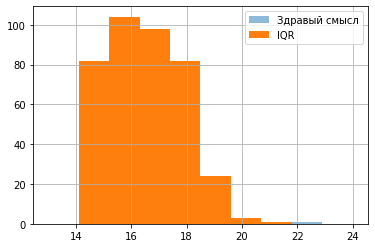

In [8]:
print_column_hist(df[col_name], (15,22))

У признака приблизительно нормальное распределение (форма гистограммы, среднее близко к медиане). Распределение смещено в сторону возрастов 16-19. Если пользоваться критерием интерквартильного расстояния, то значения выше 21 являются выбросами (1 значение в колонке). С другой стороны, переменная возраста может принимать значения от 15 до 22, поэтому нет необходимости устранять этот выброс. Данные в колонке пригодны для дальнейшего анализа.

# 4. Address — тип адреса ('U', 'R')
Проверим данные на корректность значений.

In [9]:
col_name = 'address'
check_discrete_values(df[col_name], ('U', 'R'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
U,295,78.0
R,83,22.0


378

Количество пропусков: 17
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [10]:
fill_absence_values(df, col_name)
print_column_info(df[col_name])

13.0 [0, 13] U
4.0 [13, 17] R


,Кол-во,%
U,308,78.0
R,87,22.0


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 5. Famsize — размер семьи ('LE3', 'GT3')
Проверим данные на корректность значений.

In [11]:
col_name = 'famsize'
check_discrete_values(df[col_name], ('LE3', 'GT3'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
GT3,261,70.9
LE3,107,29.1


368

Количество пропусков: 27
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [12]:
fill_absence_values(df, col_name)
print_column_info(df[col_name])

19.0 [0, 19] GT3
8.0 [19, 27] LE3


,Кол-во,%
GT3,280,70.9
LE3,115,29.1


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 6. Pstatus — статус совместного жилья родителей ('T', 'A')
Проверим данные на корректность значений.

In [13]:
col_name = 'pstatus'
check_discrete_values(df[col_name], ('T', 'A'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
T,314,89.7
A,36,10.3


350

Количество пропусков: 45
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [14]:
fill_absence_values(df, col_name)
print_column_info(df[col_name])

40.0 [0, 40] T
5.0 [40, 45] A


,Кол-во,%
T,354,89.6
A,41,10.4


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 7. Medu — образование матери (0 - 4)
Проверим данные на корректность значений.

In [15]:
col_name = 'medu'
check_discrete_values(df[col_name], range(5))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
4.0,131,33.4
2.0,102,26.0
3.0,97,24.7
1.0,59,15.1
0.0,3,0.8


392

Количество пропусков: 3
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


In [16]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(5))
print_column_info(df[col_name])

1.0 [0, 1] 4.0
1.0 [1, 2] 2.0
1.0 [2, 3] 3.0
Данные корректны.


,Кол-во,%
4,132,33.4
2,103,26.1
3,98,24.8
1,59,14.9
0,3,0.8


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 8. Fedu — образование отца (0 - 4)
Проверим данные на корректность значений.

In [17]:
col_name = 'fedu'
check_discrete_values(df[col_name], range(5))
df[col_name].replace(40, 4, inplace=True)
check_discrete_values(df[col_name], range(5))
print_column_info(df[col_name])

Данные не корректны: 40.0    1
Name: fedu, dtype: int64
Данные корректны.


,Кол-во,%
2.0,106,28.6
3.0,96,25.9
4.0,89,24.0
1.0,78,21.0
0.0,2,0.5


371

Количество пропусков: 24
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


In [18]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(5))
print_column_info(df[col_name])

7.0 [0, 7] 2.0
6.0 [7, 13] 3.0
6.0 [13, 19] 4.0
5.0 [19, 24] 1.0
Данные корректны.


,Кол-во,%
2,113,28.6
3,102,25.8
4,95,24.1
1,83,21.0
0,2,0.5


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 9. Mjob — работа матери ('teacher', 'health', 'services', 'at_home', 'other') 

In [19]:
col_name = 'mjob'
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
other,133,35.4
services,98,26.1
at_home,58,15.4
teacher,55,14.6
health,32,8.5


376

Количество пропусков: 19
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


In [20]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

7.0 [0, 7] other
5.0 [7, 12] services
3.0 [12, 15] at_home
3.0 [15, 18] teacher
1.0 [18, 19] health
Данные корректны.


,Кол-во,%
other,140,35.4
services,103,26.1
at_home,61,15.4
teacher,58,14.7
health,33,8.4


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 10. Fjob — работа отца ('teacher', 'health', 'services', 'at_home', 'other') 

In [21]:
col_name = 'fjob'
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
other,197,54.9
services,102,28.4
teacher,29,8.1
at_home,16,4.5
health,15,4.2


359

Количество пропусков: 36
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


In [22]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('teacher','health','services','at_home','other'))
print_column_info(df[col_name])

20.0 [0, 20] other
10.0 [20, 30] services
3.0 [30, 33] teacher
2.0 [33, 35] at_home
1.0 [35, 36] health
Данные корректны.


,Кол-во,%
other,217,54.9
services,112,28.4
teacher,32,8.1
at_home,18,4.6
health,16,4.1


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 11. Reason — причина выбора школы ('home', 'reputation', 'course', 'other')

In [23]:
col_name = 'reason'
check_discrete_values(df[col_name], ('home','reputation','course','other'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
course,137,36.2
home,104,27.5
reputation,103,27.2
other,34,9.0


378

Количество пропусков: 17
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


In [24]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('home','reputation','course','other'))
print_column_info(df[col_name])

6.0 [0, 6] course
5.0 [6, 11] home
5.0 [11, 16] reputation
1.0 [16, 17] other
Данные корректны.


,Кол-во,%
course,143,36.2
home,109,27.6
reputation,108,27.3
other,35,8.9


395

Количество пропусков: 0
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 12. Guardian — опекун ('mother', 'father', 'other')

In [25]:
col_name = 'guardian'
check_discrete_values(df[col_name], ('mother','father','other'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
mother,250,68.7
father,86,23.6
other,28,7.7


364

Количество пропусков: 31
Количество уникальных значений: 3
Количество значений, встретившихся более 10 раз: 3


In [26]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('mother','father','other'))
print_column_info(df[col_name])

21.0 [0, 21] mother
7.0 [21, 28] father
3.0 [28, 31] other
Данные корректны.


,Кол-во,%
mother,271,68.6
father,93,23.5
other,31,7.8


395

Количество пропусков: 0
Количество уникальных значений: 3
Количество значений, встретившихся более 10 раз: 3


# 13. Traveltime — время в пути до школы (1 - 4)

In [27]:
col_name = 'traveltime'
check_discrete_values(df[col_name], range(1,5))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
1.0,242,65.9
2.0,96,26.2
3.0,22,6.0
4.0,7,1.9


367

Количество пропусков: 28
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 3


In [28]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,5))
print_column_info(df[col_name])

18.0 [0, 18] 1.0
7.0 [18, 25] 2.0
2.0 [25, 27] 3.0
1.0 [27, 28] 4.0
Данные корректны.


,Кол-во,%
1,260,65.8
2,103,26.1
3,24,6.1
4,8,2.0


395

Количество пропусков: 0
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 3


# 14. Studytime — время на учёбу помимо школы в неделю (1 - 4)

In [29]:
col_name = 'studytime'
check_discrete_values(df[col_name], range(1,5))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
2.0,194,50.0
1.0,103,26.5
3.0,64,16.5
4.0,27,7.0


388

Количество пропусков: 7
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


In [30]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,5))
print_column_info(df[col_name])

4.0 [0, 4] 2.0
2.0 [4, 6] 1.0
1.0 [6, 7] 3.0
Данные корректны.


,Кол-во,%
2,198,50.1
1,105,26.6
3,65,16.5
4,27,6.8


395

Количество пропусков: 0
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 14.1 Studytime, granular — переменная без описания

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


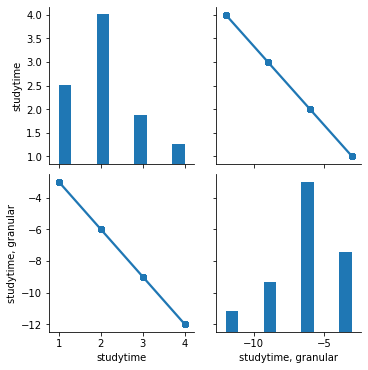

In [31]:
test_columns = ['studytime', 'studytime, granular']
sns.pairplot(df[test_columns], kind = 'reg')
df[test_columns].corr()

In [32]:
display(len(df.columns))
df.drop(['studytime, granular'], inplace = True, axis = 1)
display(len(df.columns))

30

29

# 15. Failures — количество внеучебных неудач (0 - 3)

In [33]:
col_name = 'failures'
check_discrete_values(df[col_name], range(4))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
0.0,293,78.6
1.0,49,13.1
2.0,16,4.3
3.0,15,4.0


373

Количество пропусков: 22
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


In [34]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(4))
print_column_info(df[col_name])

17.0 [0, 17] 0.0
3.0 [17, 20] 1.0
1.0 [20, 21] 2.0
1.0 [21, 22] 3.0
Данные корректны.


,Кол-во,%
0,310,78.5
1,52,13.2
2,17,4.3
3,16,4.1


395

Количество пропусков: 0
Количество уникальных значений: 4
Количество значений, встретившихся более 10 раз: 4


# 16. Schoolsup — дополнительная образовательная поддержка ('yes', 'no')

In [35]:
col_name = 'schoolsup'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
no,335,86.8
yes,51,13.2


386

Количество пропусков: 9
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [36]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

8.0 [0, 8] no
1.0 [8, 9] yes
Данные корректны.


,Кол-во,%
no,343,86.8
yes,52,13.2


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 17. Famsup — семейная образовательная поддержка ('yes', 'no')

In [37]:
col_name = 'famsup'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
yes,219,61.5
no,137,38.5


356

Количество пропусков: 39
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [38]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

24.0 [0, 24] yes
15.0 [24, 39] no
Данные корректны.


,Кол-во,%
yes,243,61.5
no,152,38.5


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 18. Paid — дополнительные платные занятия по математике ('yes', 'no')

In [39]:
col_name = 'paid'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
no,200,56.3
yes,155,43.7


355

Количество пропусков: 40
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [40]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

23.0 [0, 23] no
17.0 [23, 40] yes
Данные корректны.


,Кол-во,%
no,223,56.5
yes,172,43.5


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 19. Activities — дополнительные внеучебные занятия ('yes', 'no')

In [41]:
col_name = 'activities'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
yes,195,51.2
no,186,48.8


381

Количество пропусков: 14
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [42]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

7.0 [0, 7] yes
7.0 [7, 14] no
Данные корректны.


,Кол-во,%
yes,202,51.1
no,193,48.9


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 20. Nursery — посещал детский сад ('yes', 'no')

In [43]:
col_name = 'nursery'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
yes,300,79.2
no,79,20.8


379

Количество пропусков: 16
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [44]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

13.0 [0, 13] yes
3.0 [13, 16] no
Данные корректны.


,Кол-во,%
yes,313,79.2
no,82,20.8


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 21. Higher — хочет получить высшее образование ('yes', 'no')

In [45]:
col_name = 'higher'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
yes,356,94.9
no,19,5.1


375

Количество пропусков: 20
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [46]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

19.0 [0, 19] yes
1.0 [19, 20] no
Данные корректны.


,Кол-во,%
yes,375,94.9
no,20,5.1


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 22. Internet — наличие интернета дома ('yes', 'no')

In [47]:
col_name = 'internet'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
yes,305,84.5
no,56,15.5


361

Количество пропусков: 34
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [48]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

29.0 [0, 29] yes
5.0 [29, 34] no
Данные корректны.


,Кол-во,%
yes,334,84.6
no,61,15.4


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 23. Romantic — в романтических отношениях ('yes', 'no')

In [49]:
col_name = 'romantic'
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
no,240,65.9
yes,124,34.1


364

Количество пропусков: 31
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


In [50]:
fill_absence_values(df, col_name)
check_discrete_values(df[col_name], ('yes', 'no'))
print_column_info(df[col_name])

20.0 [0, 20] no
11.0 [20, 31] yes
Данные корректны.


,Кол-во,%
no,260,65.8
yes,135,34.2


395

Количество пропусков: 0
Количество уникальных значений: 2
Количество значений, встретившихся более 10 раз: 2


# 24. Famrel — семейные отношения (1 - 5)

In [51]:
col_name = 'famrel'

check_discrete_values(df[col_name], range(1,6))
df[col_name].replace(-1, 1, inplace=True)
check_discrete_values(df[col_name], range(1,6))

print_column_info(df[col_name])

Данные не корректны: -1.0    1
Name: famrel, dtype: int64
Данные корректны.


,Кол-во,%
4.0,182,49.5
5.0,99,26.9
3.0,62,16.8
2.0,17,4.6
1.0,8,2.2


368

Количество пропусков: 27
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


In [52]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

13.0 [0, 13] 4.0
7.0 [13, 20] 5.0
5.0 [20, 25] 3.0
1.0 [25, 26] 2.0
1.0 [26, 27] 1.0
Данные корректны.


,Кол-во,%
4,195,49.4
5,106,26.8
3,67,17.0
2,18,4.6
1,9,2.3


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 4


# 25. Freetime — свободное время после школы (1 - 5)

In [53]:
col_name = 'freetime'
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
3.0,153,39.8
4.0,112,29.2
2.0,63,16.4
5.0,38,9.9
1.0,18,4.7


384

Количество пропусков: 11
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


In [54]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

4.0 [0, 4] 3.0
3.0 [4, 7] 4.0
2.0 [7, 9] 2.0
1.0 [9, 10] 5.0
1.0 [10, 11] 1.0
Данные корректны.


,Кол-во,%
3,157,39.7
4,115,29.1
2,65,16.5
5,39,9.9
1,19,4.8


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 26. Goout — проведение времени с друзьями (1 - 5)

In [55]:
col_name = 'goout'
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
3.0,127,32.8
2.0,101,26.1
4.0,84,21.7
5.0,52,13.4
1.0,23,5.9


387

Количество пропусков: 8
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


In [56]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

3.0 [0, 3] 3.0
2.0 [3, 5] 2.0
2.0 [5, 7] 4.0
1.0 [7, 8] 5.0
Данные корректны.


,Кол-во,%
3,130,32.9
2,103,26.1
4,86,21.8
5,53,13.4
1,23,5.8


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 27. Health — текущее состояние здоровья (1 - 5)

In [57]:
col_name = 'health'
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
5.0,138,36.3
3.0,89,23.4
4.0,63,16.6
1.0,47,12.4
2.0,43,11.3


380

Количество пропусков: 15
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


In [58]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(1,6))
print_column_info(df[col_name])

5.0 [0, 5] 5.0
4.0 [5, 9] 3.0
2.0 [9, 11] 4.0
2.0 [11, 13] 1.0
2.0 [13, 15] 2.0
Данные корректны.


,Кол-во,%
5,143,36.2
3,93,23.5
4,65,16.5
1,49,12.4
2,45,11.4


395

Количество пропусков: 0
Количество уникальных значений: 5
Количество значений, встретившихся более 10 раз: 5


# 28. Absences — количество пропущенных занятий

In [59]:
col_name = 'absences'

check_discrete_values(df[col_name], range(366))
df = remove_value(df, col_name, 385)
check_discrete_values(df[col_name], range(366))

print_column_info(df[col_name])
df[col_name].describe()

Данные не корректны: 385.0    1
Name: absences, dtype: int64
Данные корректны.


,Кол-во,%
0.0,111,29.1
2.0,60,15.7
4.0,53,13.9
6.0,31,8.1
8.0,21,5.5
10.0,17,4.5
12.0,12,3.1
14.0,12,3.1
3.0,8,2.1
16.0,7,1.8


... остальные значения


382

Количество пропусков: 12
Количество уникальных значений: 35
Количество значений, встретившихся более 10 раз: 8


count    382.000000
mean       6.290576
std       13.289503
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      212.000000
Name: absences, dtype: float64

In [60]:
fill_absence_values(df, col_name)
df[col_name] = df[col_name].astype('int64')
check_discrete_values(df[col_name], range(366))
print_column_info(df[col_name])
df[col_name].describe()

3.0 [0, 3] 0.0
2.0 [3, 5] 2.0
2.0 [5, 7] 4.0
1.0 [7, 8] 6.0
1.0 [8, 9] 8.0
1.0 [9, 10] 10.0
1 [10, 11] 12.0
1 [11, 12] 14.0
Данные корректны.


,Кол-во,%
0,114,28.9
2,62,15.7
4,55,14.0
6,32,8.1
8,22,5.6
10,18,4.6
14,13,3.3
12,13,3.3
3,8,2.0
16,7,1.8


... остальные значения


394

Количество пропусков: 0
Количество уникальных значений: 35
Количество значений, встретившихся более 10 раз: 8


count    394.000000
mean       6.256345
std       13.111686
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      212.000000
Name: absences, dtype: float64

count    394.000000
mean       6.256345
std       13.111686
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      212.000000
Name: absences, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 8.0 
IQR: 8.0, Границы выбросов: [-12.0, 20.0].


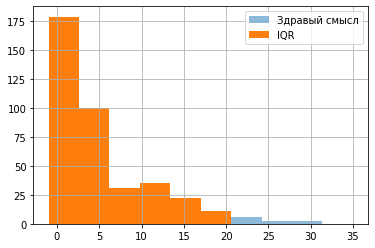

In [61]:
print_column_hist(df[col_name], (0,365), (-1,35))

До 30

In [62]:
df = df[df[col_name] <= 30]
df[col_name].describe()

count    388.000000
mean       5.128866
std        5.821096
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

# 29. Score — баллы по госэкзамену по математике

In [63]:
col_name = 'score'
df = df[~(df[col_name].isnull() | df[col_name].isna())]
df[col_name] = df[col_name].astype('int64')

check_discrete_values(df[col_name], range(101))
print_column_info(df[col_name])

Данные корректны.


,Кол-во,%
50,54,14.1
55,44,11.5
0,37,9.7
75,33,8.6
65,31,8.1
60,31,8.1
40,29,7.6
70,27,7.1
45,25,6.5
80,16,4.2


... остальные значения


382

Количество пропусков: 0
Количество уникальных значений: 18
Количество значений, встретившихся более 10 раз: 12


count    382.000000
mean      52.264398
std       23.043739
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

25-й перцентиль: 40.0, 75-й перцентиль: 70.0 
IQR: 30.0, Границы выбросов: [-5.0, 115.0].


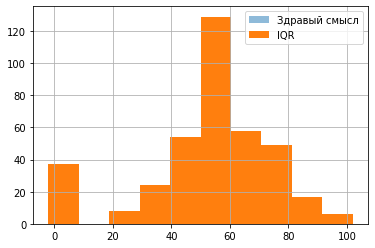

In [64]:
print_column_hist(df[col_name], (0,100))

# Данные после первичной обработки

In [65]:
check_absence_values(df)
print(f'Было выброшено {df_len - len(df)} строк')

Данные не содержат пропуски.
Было выброшено 13 строк


# Корреляционный анализ

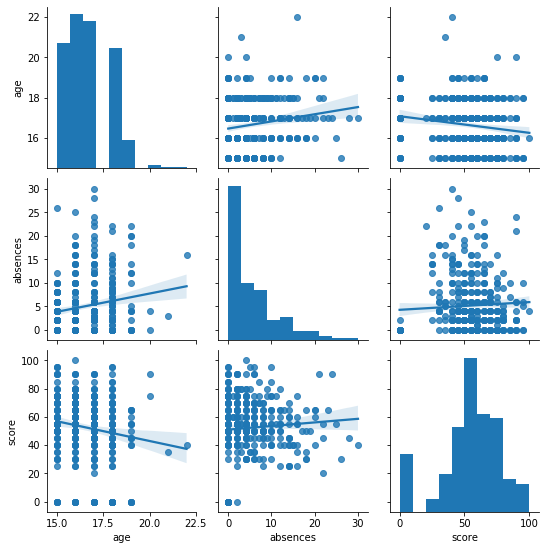

In [66]:
numeric_columns = ['age', 'absences', 'score'] 
sns.pairplot(df[numeric_columns], kind = 'reg')

In [67]:
df[numeric_columns].corr()

,age,absences,score
age,1.000000,0.166209,-0.151888
absences,0.166209,1.000000,0.064646
score,-0.151888,0.064646,1.000000


# Анализ номинативных переменных

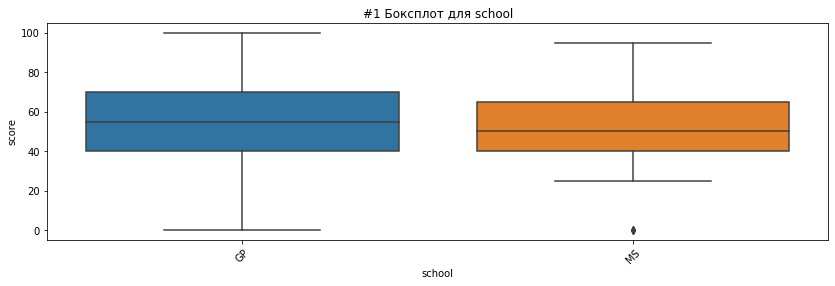

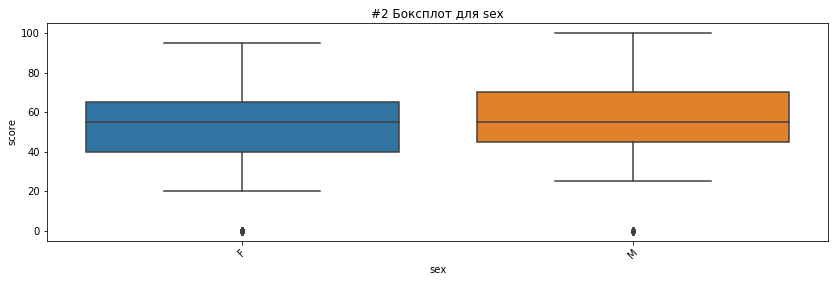

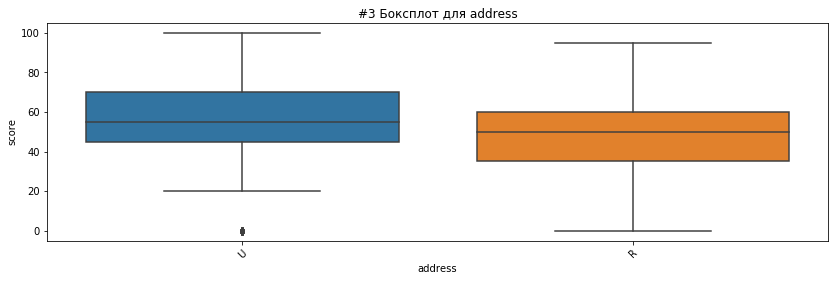

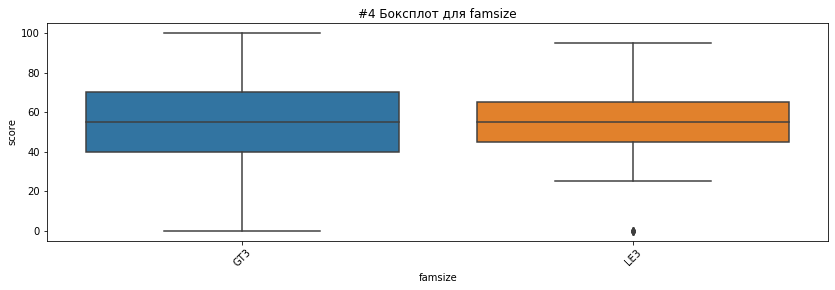

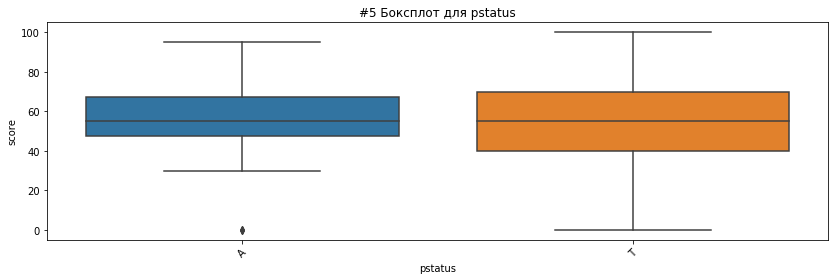

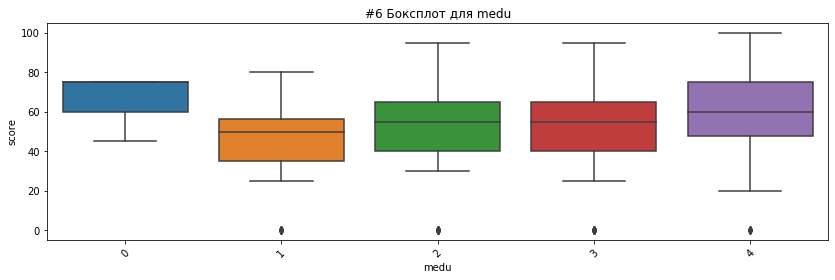

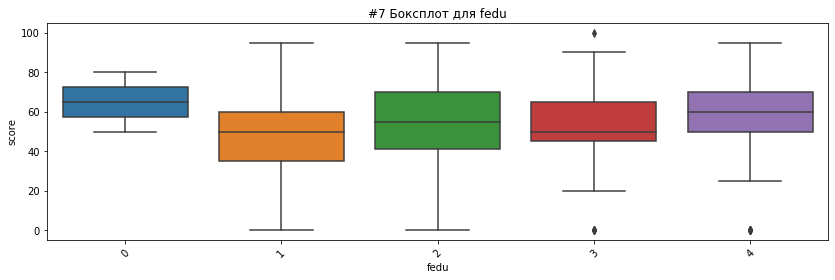

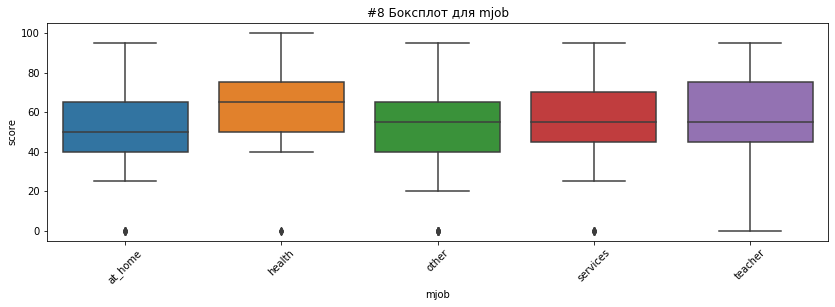

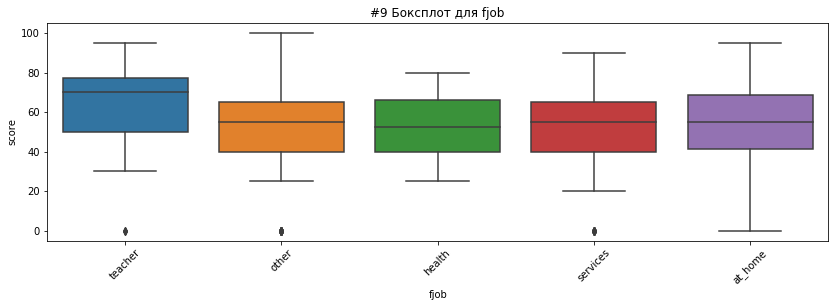

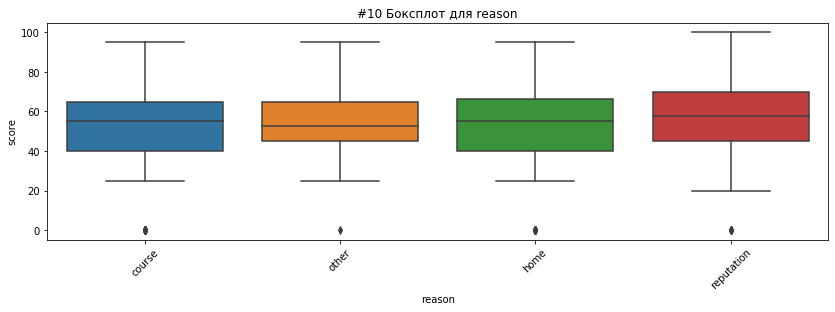

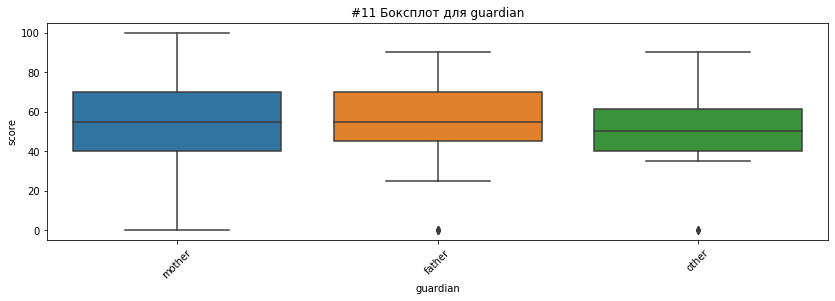

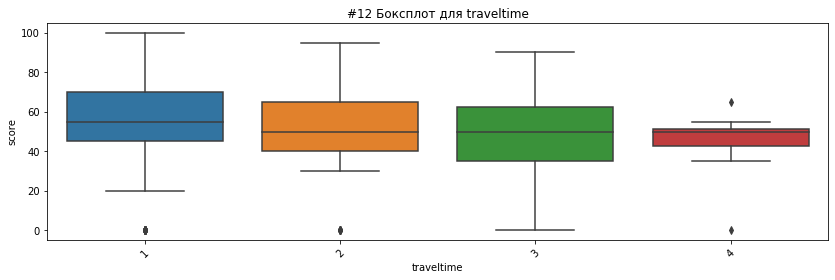

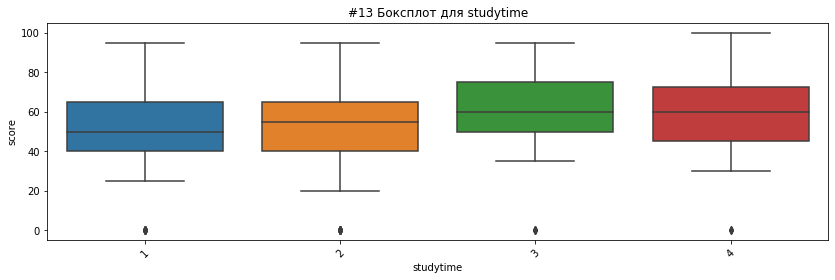

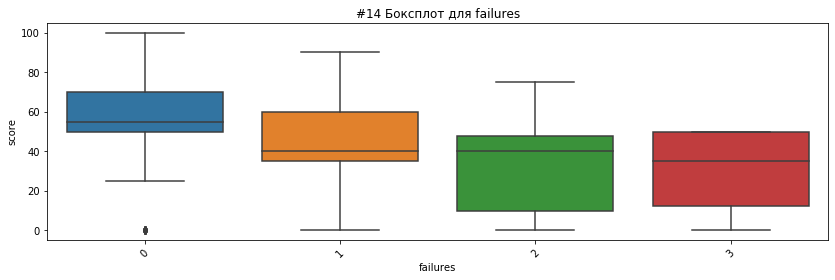

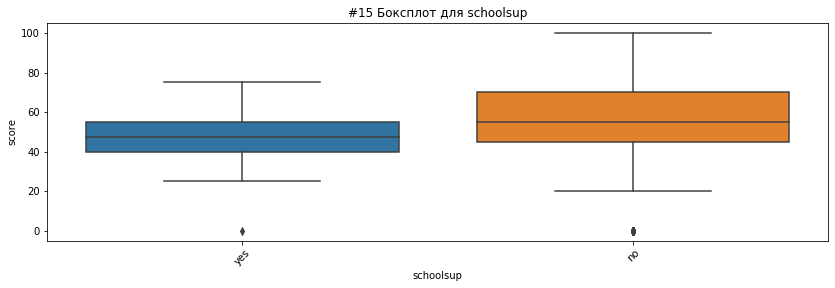

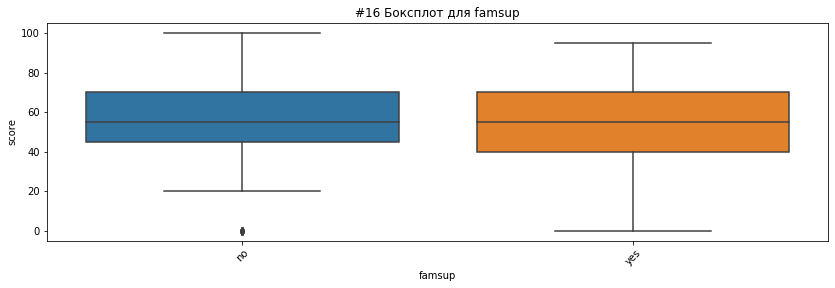

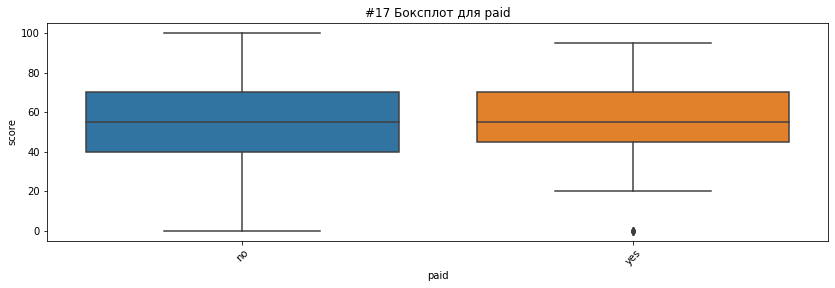

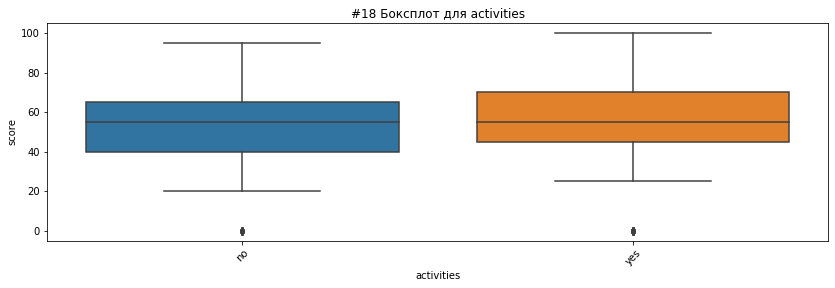

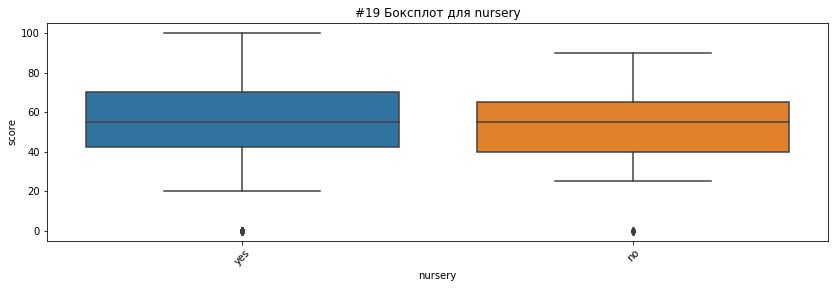

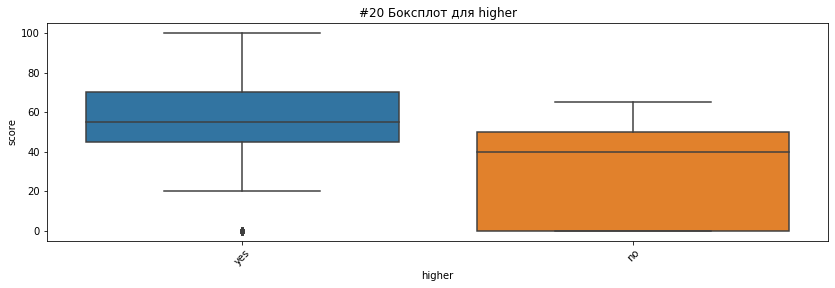

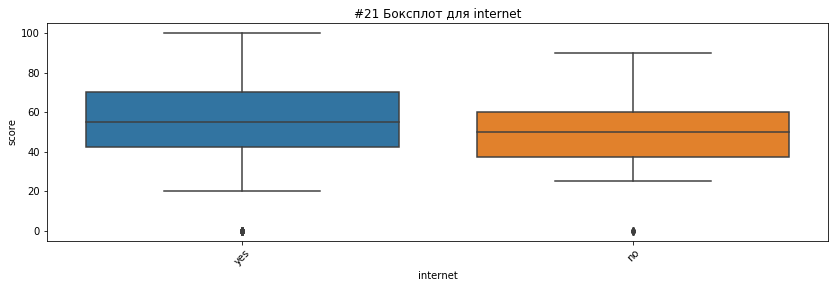

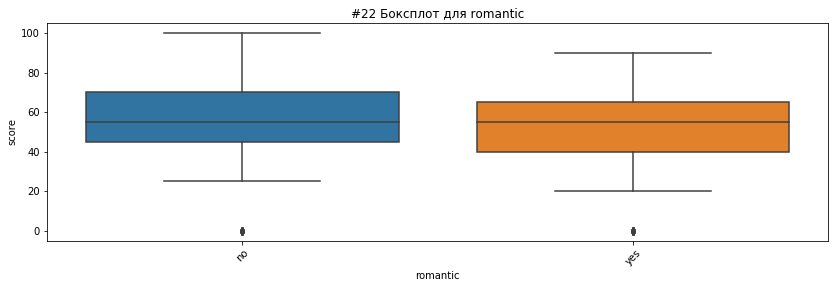

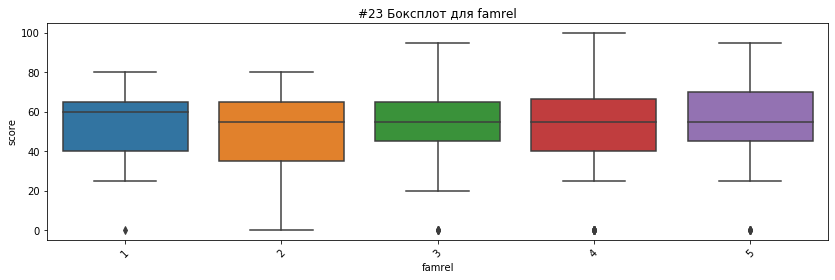

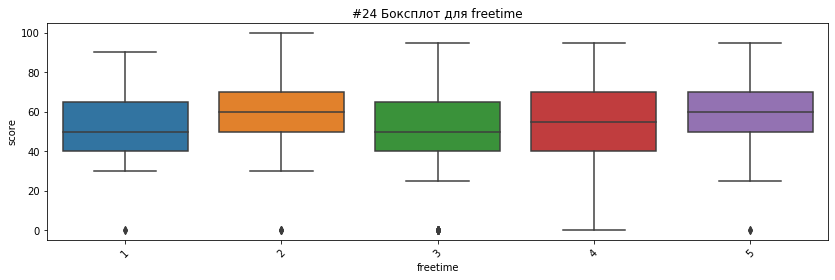

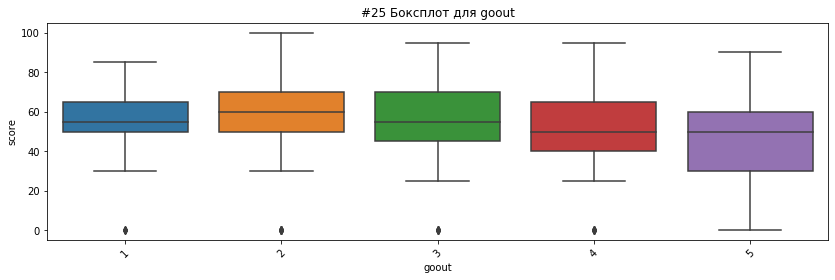

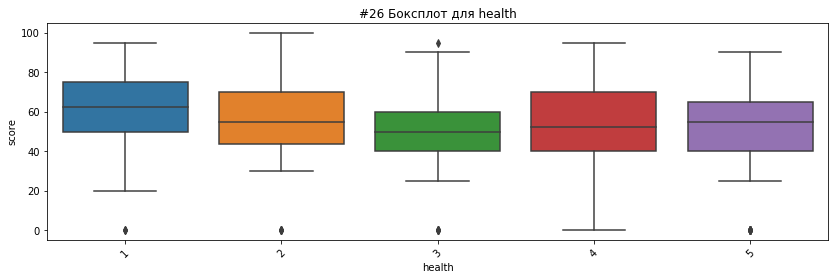

In [68]:
counter = 0
for col_name in df.columns:
    if not col_name in numeric_columns:
        counter += 1
        get_boxplot(df, col_name, counter)

In [69]:
count = 0
list_columns = []
for col_name in df.columns:
    if not col_name in numeric_columns:
        count += 1
        isFound = get_stat_dif(df, col_name)
        if isFound:
            list_columns.append(col_name)
        
list_columns.extend(numeric_columns)        
print(count, list_columns)        

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
26 ['sex', 'address', 'medu', 'failures', 'schoolsup', 'higher', 'romantic', 'age', 'absences', 'score']


# Данные после анализа

In [70]:
df_for_model = df.loc[:, list_columns]
df_for_model.head()

,sex,address,medu,failures,schoolsup,higher,romantic,age,absences,score
0,F,U,4,0,yes,yes,no,18,6,30
1,F,U,1,0,no,yes,no,17,4,30
2,F,U,1,3,yes,yes,no,15,10,50
3,F,U,4,0,no,yes,yes,15,2,75
4,F,U,3,0,no,yes,no,16,4,50


# Выводы